## Regression and predictive modeling of Rossmann stores daily sales

**1. Prepare Problem**

In [1]:
# a) Load libraries

import os
import itertools

import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# b) Load dataset
# Get all the files in the working directory
cwd = os.getcwd()
files = os.listdir(cwd)
print("List files in %r: %s" % (cwd, files))

# Load and view each file in the dataset
raw_train = pd.read_csv('train.csv', header=0)
print(raw_train.shape)
print(raw_train.head(10))
print(raw_train.dtypes)

raw_test = pd.read_csv('test.csv', header=0)
print(raw_test.shape)
print(raw_test.head(10))
print(raw_test.dtypes)

store = pd.read_csv('store.csv', header=0)
print(store.shape)
print(store.head(10))
print(store.dtypes)

List files in 'D:\\PROJECTS\\GitHub_Projects\\Prediction rossman store sales': ['.ipynb_checkpoints', 'Rossmann_store_sales_NN.py', 'Rossmann_store_sales_NN_23Nov.py', 'Rossmann_store_sales_NN_25Nov.py', 'Rossmann_store_sales_NN_30Nov.py', 'Rossmann_store_sales_NN_OK.py', 'Rossmann_store_sales_NN_V1.py', 'sample_submission.csv', 'store.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']
(1017209, 9)
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   
5      6          5  2015-07-31   5651        589     1      1            0   
6      7          5  2015-07-31  15344       14

D:\Software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Merge the store data to train dataset
data = raw_train.merge(store,on=["Store"], how="inner")
print(data.shape)
print(data.dtypes)

(1017209, 18)
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


**2. Dataset summary**

In [5]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

           Store  DayOfWeek      Sales  Customers       Open      Promo  SchoolHoliday  \
count  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06      1.017e+06   
mean   5.584e+02  3.998e+00  5.774e+03  6.331e+02  8.301e-01  3.815e-01      1.786e-01   
std    3.219e+02  1.997e+00  3.850e+03  4.644e+02  3.755e-01  4.858e-01      3.831e-01   
min    1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00      0.000e+00   
25%    2.800e+02  2.000e+00  3.727e+03  4.050e+02  1.000e+00  0.000e+00      0.000e+00   
50%    5.580e+02  4.000e+00  5.744e+03  6.090e+02  1.000e+00  0.000e+00      0.000e+00   
75%    8.380e+02  6.000e+00  7.856e+03  8.370e+02  1.000e+00  1.000e+00      0.000e+00   
max    1.115e+03  7.000e+00  4.155e+04  7.388e+03  1.000e+00  1.000e+00      1.000e+00   

       CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear     Promo2  \
count            1.015e+06                 693861.000                693861.000  1.017e+06   
m

In [6]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

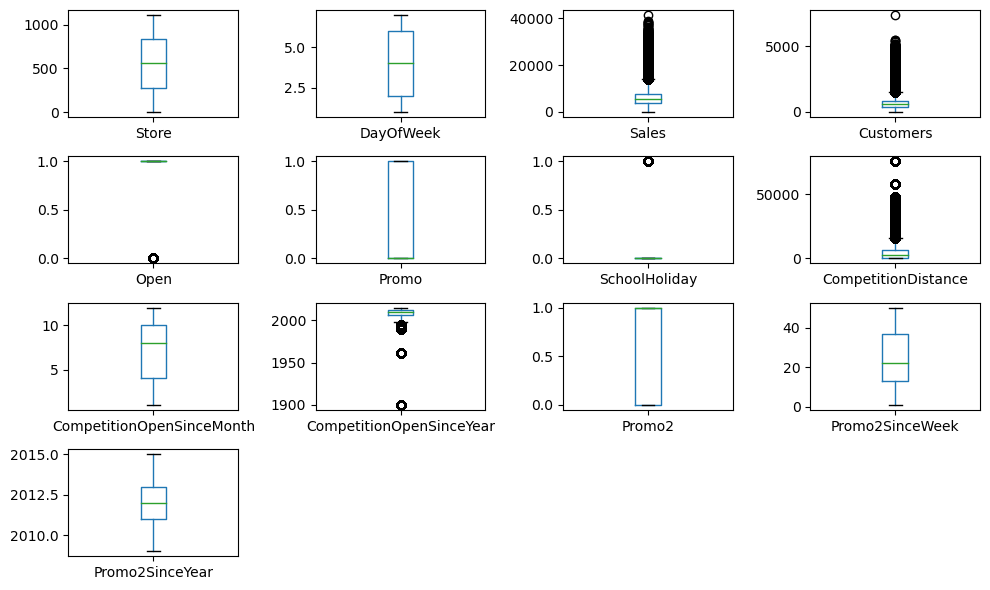

In [7]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

We can see the data skewed to the low values in Sales, Customers, and CompetitionDistance

                               Store  DayOfWeek  Sales  Customers       Open      Promo  \
Store                      1.000e+00 -8.484e-06  0.005      0.024 -4.674e-05  5.786e-05   
DayOfWeek                 -8.484e-06  1.000e+00 -0.462     -0.386 -5.290e-01 -3.929e-01   
Sales                      5.126e-03 -4.621e-01  1.000      0.895  6.785e-01  4.523e-01   
Customers                  2.432e-02 -3.864e-01  0.895      1.000  6.168e-01  3.162e-01   
Open                      -4.674e-05 -5.290e-01  0.678      0.617  1.000e+00  2.950e-01   
Promo                      5.786e-05 -3.929e-01  0.452      0.316  2.950e-01  1.000e+00   
SchoolHoliday              6.407e-04 -2.054e-01  0.085      0.072  8.617e-02  6.748e-02   
CompetitionDistance       -2.641e-02 -2.461e-05 -0.019     -0.103  7.992e-03  1.382e-04   
CompetitionOpenSinceMonth -5.075e-02  5.882e-06 -0.028     -0.031  1.384e-03 -2.295e-05   
CompetitionOpenSinceYear  -4.592e-03 -2.537e-05  0.013      0.009  2.771e-03  1.524e-04   

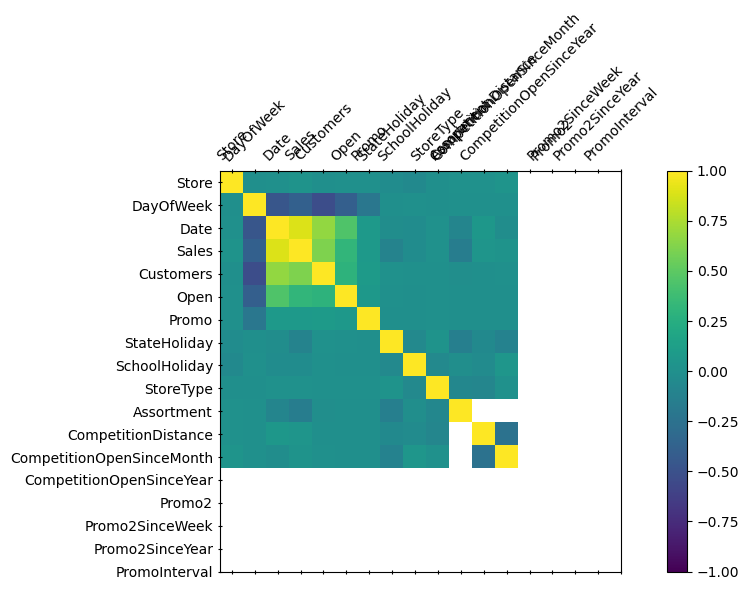

In [8]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,18))
sub_fig.set_yticks(np.arange(0,18))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates sales data is sensitive to the Date and Customers features

**3. Prepare Data**

In [9]:
# a) Data Cleaning

# Extract year, month, week, day from the Date feature

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.week
data["Day"] = data["Date"].dt.day

# Create 2 new features representing weekend and promotion
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend","Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

y_temp = data['Sales']

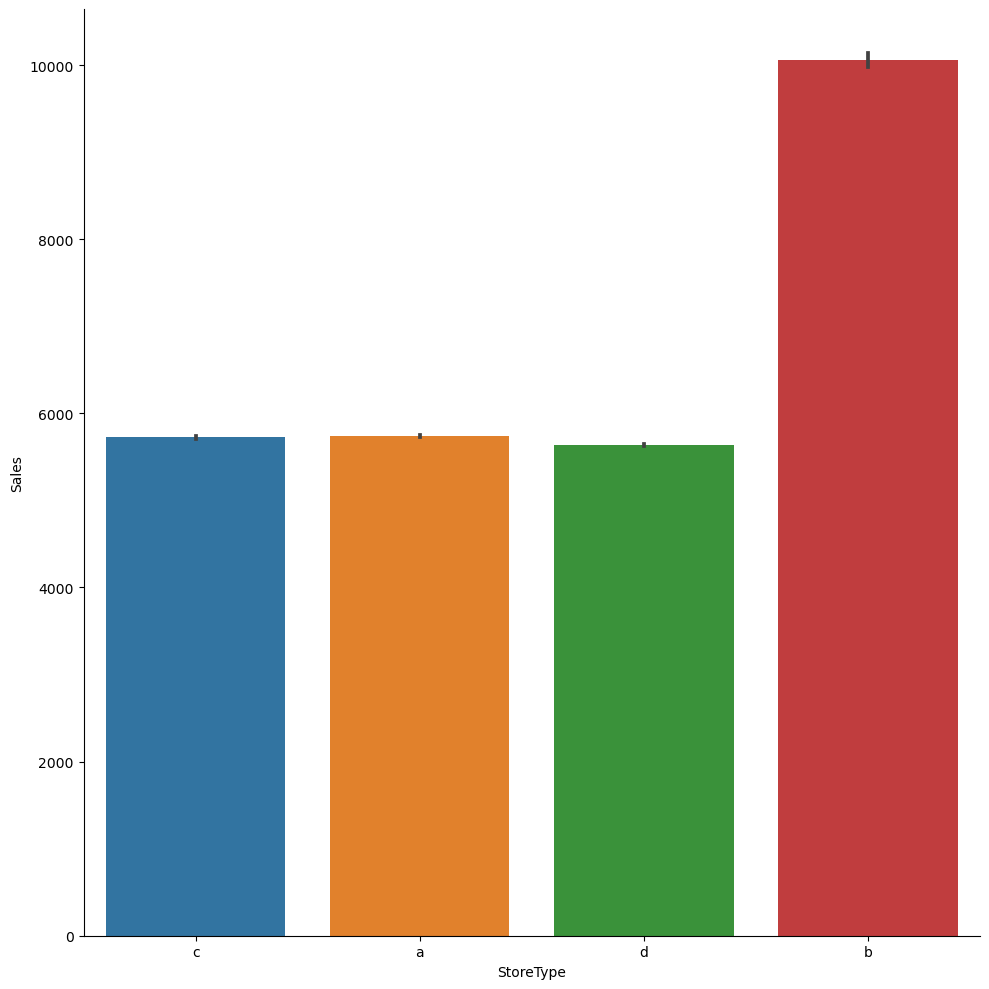

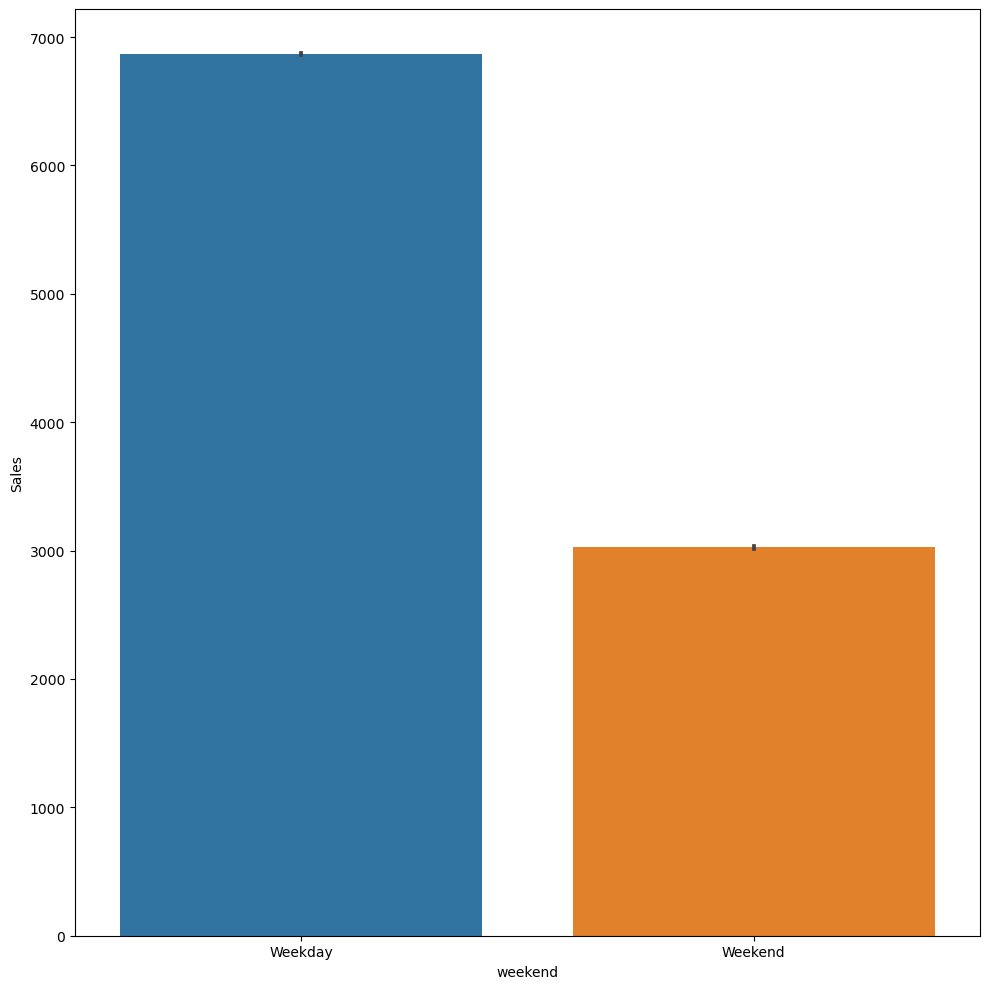

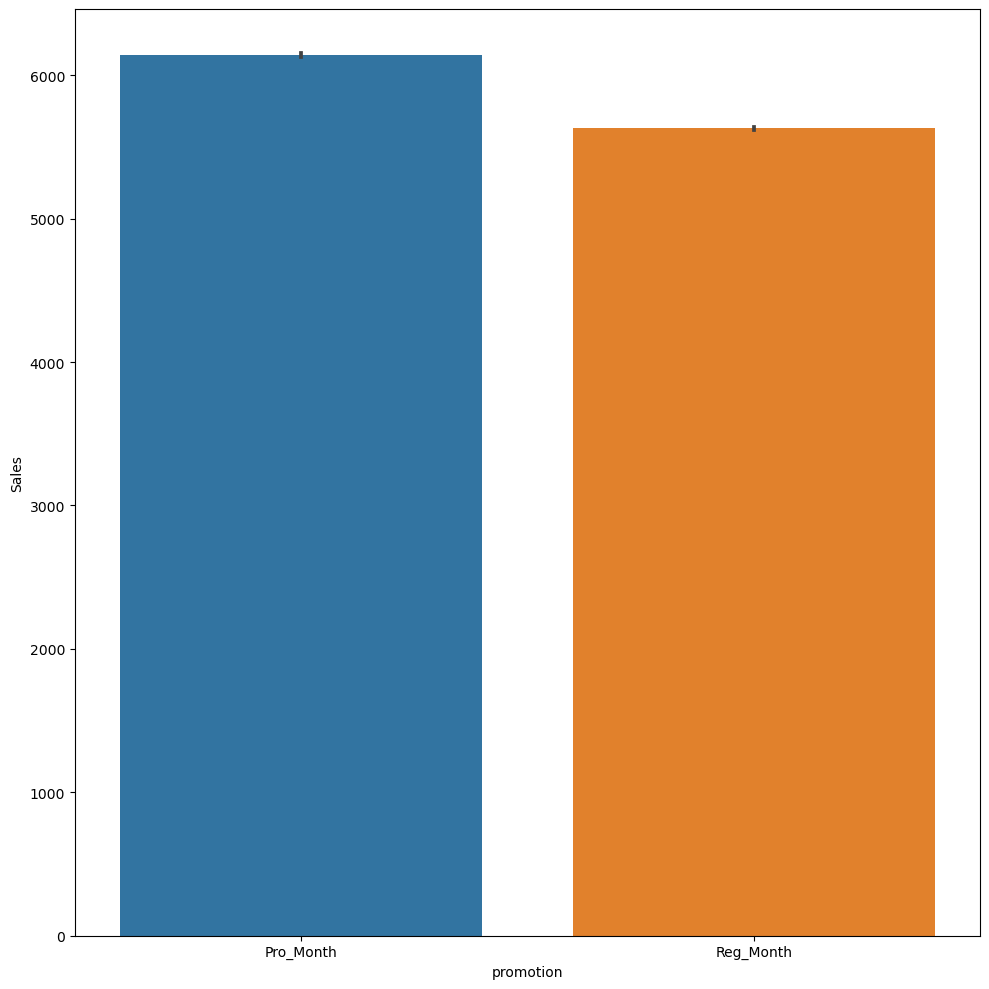

In [10]:
# Visualize Sales vs. store type 
fig1, ax1 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['StoreType'], y=y_temp, data=data, ax=ax1)

# Visualize Sales vs. weekend
fig2, ax2 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['weekend'], y=y_temp, data=data, ax=ax2)

# Visualize Sales vs. promotion months 
fig3, ax3 = plt.subplots(figsize=(10, 10))
sn.barplot(x=data['promotion'], y=y_temp, data=data, ax=ax3)
sn.despine(fig1, fig2, fig3)

An interesting observation from the Sales vs Weekend chart is that sales on weekdays are generally higher than on weekends (Saturday and Sunday).

In [11]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     5
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
Year                             3
Month                           12
Week                            52
Day                             31
weekend                          2
promotion                        2
dtype: int64
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Cus

In [12]:
# Impute missing values with 'mode' values
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [13]:
# Convert strings into categorial classes
data['StoreType'].replace('a', 1, inplace = True)
data['StoreType'].replace('b', 2, inplace = True)
data['StoreType'].replace('c', 3, inplace = True)
data['StoreType'].replace('d', 4, inplace = True)

data['Assortment'].replace('a', 1, inplace = True)
data['Assortment'].replace('b', 2, inplace = True)
data['Assortment'].replace('c', 3, inplace = True)

data['StateHoliday'].replace('0', 0, inplace = True)
data['StateHoliday'].replace('a', 1, inplace = True)
data['StateHoliday'].replace('b', 2, inplace = True)
data['StateHoliday'].replace('c', 3, inplace = True)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])

In [14]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(1017209, 26)


In [15]:
# b) Split-out validation dataset and drop unimportant columns

df = data.drop(columns=['Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)

X = df.drop(columns=['Sales'], axis = 1)
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(712046, 18) (305163, 18)
(712046,) (305163,)


**4. Evaluate Algorithms**

In [55]:
# a) Spot check algorithms
# ML: Linear Regression
results = []
names = []

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
LR = model_LR.score(X_test, y_test)
results.append(LR)
names.append('LR')

([<matplotlib.axis.YTick at 0x2c581eea160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

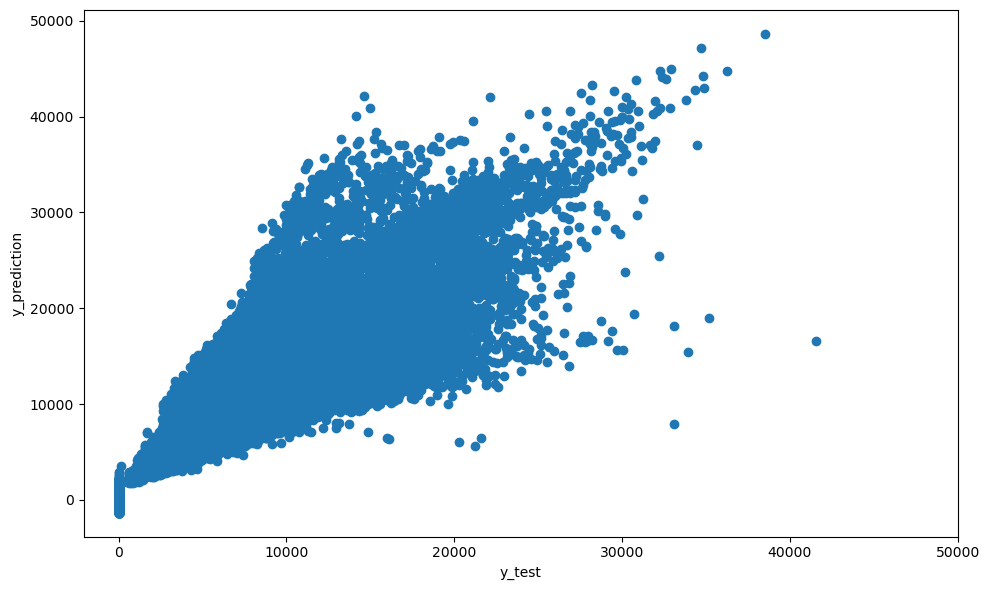

In [56]:
# Plot y_test vs prediction
plt.scatter(y_test, y_pred_LR)
plt.xlabel("y_test")
plt.ylabel("y_prediction")
plt.xticks(np.arange(0, 60000, 10000))
plt.yticks(np.arange(0, 60000, 10000))

The data points align along the 45 deg line indicating good match between test and prediction data.

([<matplotlib.axis.YTick at 0x2c581f487f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

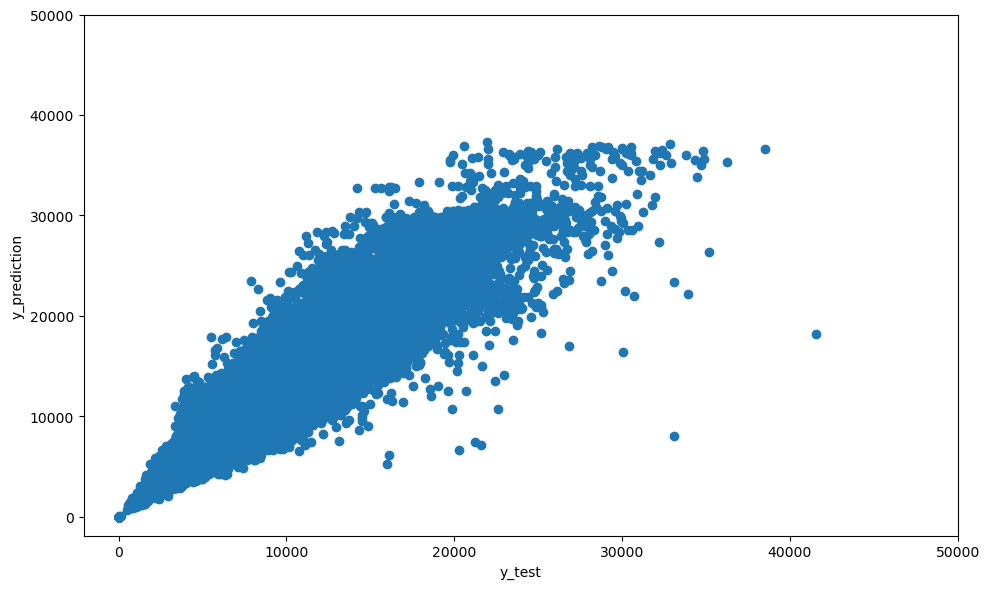

In [57]:
# Ensemble: Random Forest algorithm
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
RF = model_RF.score(X_test, y_test)
results.append(RF)
names.append('RF')

# Plot y_test vs prediction
plt.scatter(y_test, y_pred_RF)
plt.xlabel("y_test")
plt.ylabel("y_prediction")
plt.xticks(np.arange(0, 60000, 10000))
plt.yticks(np.arange(0, 60000, 10000))

Again, We see data points aligning along the 45 deg line indicating good match between test and prediction data.

In [58]:
# XGBoost algorithm
# Use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed.
df_xgb = xgb.DMatrix(data=X, label=y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3)

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)

model_xgb.fit(X_train2,y_train2)

# Prediction
preds = model_xgb.predict(X_test2)
XGB = model_xgb.score(X_test2, y_test2)
results.append(XGB)
names.append('XGB')

In [59]:
# Compare algorithms
print(names, results)

['LR', 'RF', 'XGB'] [0.66027444950881, 0.5176164754740655, 0.6569140337992909]


The Linear Regression surprisingly performs much better than Random Forest and on par with XGBoost, the most powerful regression algorithm.

In [61]:
# b) Neural Network algorithms
# create keras Sequential model with 3 layers
NN_model = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (18, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

Epoch 1/20
11126/11126 [==============================] - 34s 3ms/step - loss: 0.7905 - mse: 8787157.0000 - val_loss: 0.0723 - val_mse: 4109848.5000
Epoch 2/20
11126/11126 [==============================] - 35s 3ms/step - loss: 0.0394 - mse: 2269004.5000 - val_loss: 0.0863 - val_mse: 6113685.5000
Epoch 3/20
11126/11126 [==============================] - 42s 4ms/step - loss: 0.0345 - mse: 2121249.7500 - val_loss: 0.0835 - val_mse: 5986643.5000
Epoch 4/20
11126/11126 [==============================] - 39s 4ms/step - loss: 0.0325 - mse: 2030418.7500 - val_loss: 0.0786 - val_mse: 5880811.5000
Epoch 5/20
11126/11126 [==============================] - 39s 4ms/step - loss: 0.0314 - mse: 1976835.1250 - val_loss: 0.0762 - val_mse: 5506323.5000
Epoch 6/20
11126/11126 [==============================] - 46s 4ms/step - loss: 0.0310 - mse: 1951684.0000 - val_loss: 0.0733 - val_mse: 5569617.5000
Epoch 7/20
11126/11126 [==============================] - 46s 4ms/step - loss: 0.0305 - mse: 1932980.6250 

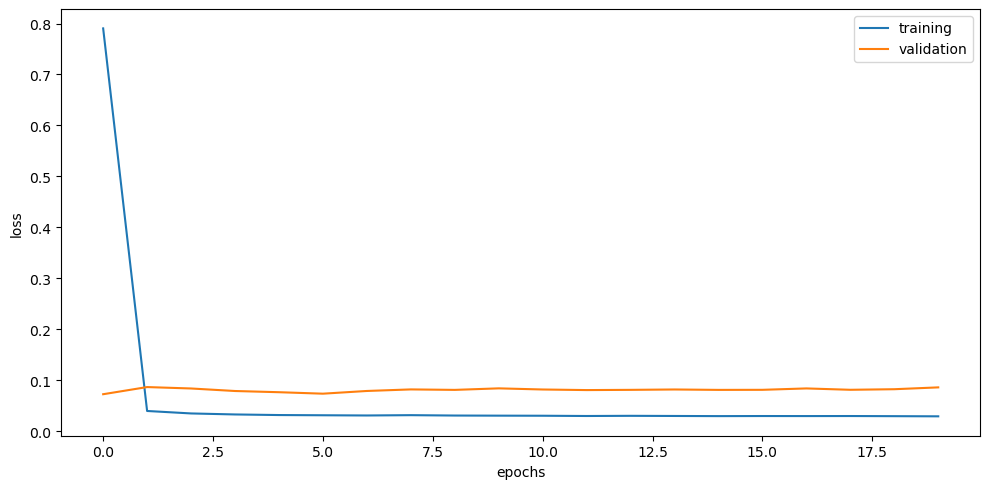

In [62]:
# fit the keras model on the dataset
model_fit = NN_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=64)

# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_fit.history['loss'], label = 'training')
plt.plot(model_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The loss value of the training (0.029) and validation (0.086) are fairly low meaning fairly good prediction probability to the corresponding true value.  

**6. Finalize Model**

9537/9537 [==============================] - 12s 1ms/step
(305163, 1)
(305163,) (305163,)


([<matplotlib.axis.YTick at 0x2c5d1624220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

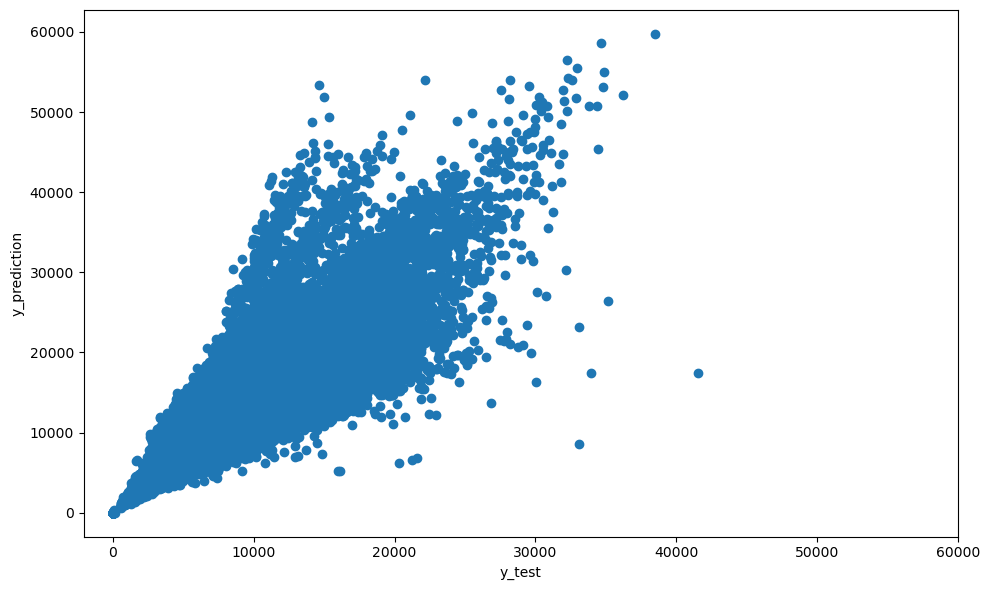

In [65]:
# a) Predictions on validation dataset
# Keras Sequential model estimate accuracy on validation dataset
y_pred = NN_model.predict(X_test)
print(y_pred.shape)
y_pred2 = np.array(list(itertools.chain(*y_pred)))

print(y_test.shape, y_pred2.shape)
plt.scatter(y_test, y_pred2)
plt.xlabel("y_test")
plt.ylabel("y_prediction")
plt.xticks(np.arange(0, 70000, 10000))
plt.yticks(np.arange(0, 70000, 10000))

In [66]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(NN_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://ad1905b7-c4c1-4cd7-a00f-2ab086c16099/assets


**6. Conclusions**

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.

- Of the three ML algorithms, Linear Regression and XGBoost achieved better score than Random Forest (0.66 vs. 0.52).

- The performance of the neural network model (Keras Sequential) with 3 layers and dropput regulation seems to be comparable to the Linear Regression. Further tunning of the hyperparameter may yield a better prediction score.